<img src="image_loand_default_mlops.png" alt="image" style="width:1300px;height:400px;">

Dans cette partie, nous nous concentrons sur la mise en œuvre, l'entraînement et l'évaluation de modèles, tout en utilisant Mlflow pour enregistrer les paramètres, les métriques et les artefacts.

## 1. Data Processing

In [4]:
# chargement des library
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Set environment variables
data_path = "Data/Processed_Loan_Data.csv"
models_path = "Models/"

In [6]:
# Cnnect to the MLflow tracking server
try:
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    client = mlflow.MlflowClient(tracking_uri="http://127.0.0.1:8080")
    print("Connected to MLflow server")
except:
    print(
        "MLflow server is not running!\nPlease execute the cell above in a terminal to launch the MLflow server."
    )

Connected to MLflow server


## 

In [7]:
df = pd.read_csv(data_path)
df.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,0.747096,-0.724848,0.398555,5,-0.536770,0
1,5,-1.548375,-0.073967,-2.161876,2,-1.080832,1
2,0,-0.560509,-1.009696,-0.207919,4,-0.586230,0
3,0,0.427045,-0.938184,0.215083,5,-0.421363,0
4,1,-1.979733,-1.048780,-2.321314,6,-0.108115,0


In [8]:
# Séparation des données
X = df.drop(columns=["default"])
y = df["default"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

**Mlflow connect**

In [10]:
import mlflow.sklearn
def eval_log_model(model, X_test, y_test, y_pred, params, run_name):
    """
    Évalue et enregistre un modèle.

    Paramètres :
    model (object): Le modèle à évaluer.
    X_test (array-like): Les données de test des caractéristiques.
    y_test (array-like): Les données de test des cibles.
    y_pred (array-like): Les prédictions du modèle.
    params (dict): Les paramètres du modèle de régression logistique.
    run_name (str): Le nom de l'exécution MLflow.

    Retourne :
    dict: Un dictionnaire contenant les métriques d'évaluation.
    matplotlib.figure.Figure: La figure de la matrice de confusion.
    """

    # Générer un rapport de classification et une matrice de confusion
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extraire les valeurs de la matrice de confusion
    tn, fp, fn, tp = conf_matrix.ravel().astype(int)

    # Extraire les métriques d'évaluation pour les classes 'default' et 'no_default'
    default_precision, default_recall, default_f1_score, _ = class_report["1"].values()
    no_default_precision, no_default_recall, no_default_f1_score, _ = class_report["0"].values()

    # Créer et afficher la matrice de confusion
    fig, ax = plt.subplots(figsize=(7, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["no_default", "default"])
    cm_display.plot(ax=ax, cmap="Blues")  # Utiliser la carte de couleurs 'Blues'
    ax.set_title("Matrice de Confusion")  # Ajouter un titre

    # Compiler les métriques d'évaluation dans un dictionnaire
    metrics = {
        "default_precision": default_precision,
        "default_recall": default_recall,
        "default_f1_score": default_f1_score,
        "no_default_precision": no_default_precision,
        "no_default_recall": no_default_recall,
        "no_default_f1_score": no_default_f1_score,
        "false_positives": int(fp),
        "false_negatives": int(fn),
    }
    metrics = {k: round(v, 2) for k, v in metrics.items()}

    # Enregistrer le modèle et les métriques dans MLflow
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params(params)  # Enregistrer les paramètres du modèle
        mlflow.log_metrics(metrics)  # Enregistrer les métriques d'évaluation
        mlflow.log_figure(fig, "confusion_matrix.png")  # Enregistrer la figure de la matrice de confusion
        mlflow.sklearn.log_model(sk_model=model, artifact_path=run_name)  # Enregistrer le modèle

    return metrics, fig

In [16]:
experiment_tags = {"project_name":"Loan Default Prediction" 
                   ,"data": "Loan Data",
                   "model": "Regression logistique"}
logistic_regression_experiment = client.create_experiment(name="Regression Logistique",tags=experiment_tags)

In [17]:
mlflow.set_experiment("Régression Logistique")

2025/03/22 17:52:53 INFO mlflow.tracking.fluent: Experiment with name 'Régression Logistique' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/532934428493662448', creation_time=1742655173787, experiment_id='532934428493662448', last_update_time=1742655173787, lifecycle_stage='active', name='Régression Logistique', tags={}>

2025/03/22 17:54:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/22 17:54:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Regression_logistique_equilibree_saga_elasticnet at: http://127.0.0.1:8080/#/experiments/532934428493662448/runs/08b7ad81ee3b49e18d5b610189f6eba1.
2025/03/22 17:54:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/532934428493662448.


{'default_precision': 0.98, 'default_recall': 1.0, 'default_f1_score': 0.99, 'no_default_precision': 1.0, 'no_default_recall': 1.0, 'no_default_f1_score': 1.0, 'false_positives': 6, 'false_negatives': 0}


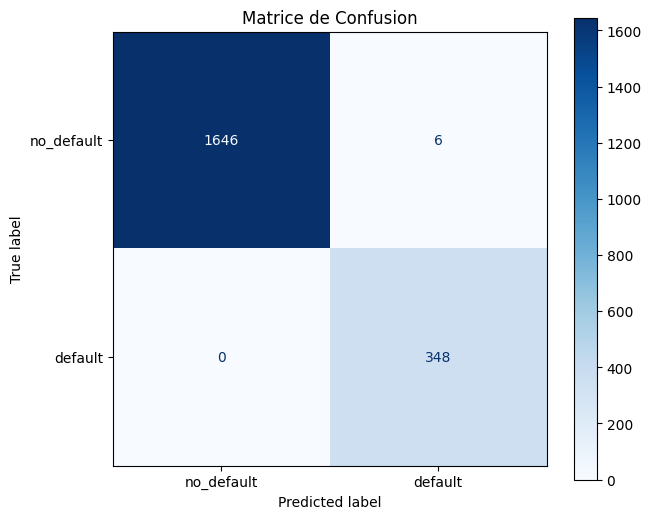

In [ ]:
# Définir les paramètres du modèle
run_name = "Regression_logistique_equilibree_saga_elasticnet"
model_params = {
    "fit_intercept": True,
    "class_weight": 'balanced',
    "penalty": 'elasticnet',
    "solver": "saga",
    "l1_ratio": 0.5,
    "max_iter": 1000,
    "random_state": 42,
}
# Créer un modèle de régression logistique avec les paramètres donnés
model = LogisticRegression(**model_params)

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Évaluer le modèle et obtenir le rapport de classification et la matrice de confusion
class_report, conf_matrix = eval_log_model(model, X_test, y_test, y_pred, model_params, run_name)

# Afficher le rapport de classification
print(class_report)


# Forêt Aléatoires

In [ ]:
#Set the experiment name
experiment_tags = {"project_name":"Loan Default Prediction" ,
                   "data": "Loan Data",
                    "model": "Random Forest"}
logistic_regression_experiment = client.create_experiment(name="Random_Forest",tags=experiment_tags)

In [ ]:
mlflow.set_experiment("Random_Forest")

In [ ]:
# Define the model parameters
run_name="Random_Forest_depth_6_estimators_50"
model_params = {
    "n_estimators": 50,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state":42,
}

model = RandomForestRegressor(**model_params)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

class_report,conf_matrix = eval_log_model(model, X_test, y_test,y_pred, model_params,run_name)

class_report